In [1]:
import functions_model_analysis as f
import numpy as np
import pandas as pd
import sys 
 
sys.path.insert(0, '../AWS_Scripts')
from functions_training_pipeline import Model

### Load models

In [139]:
LinReg = f.load_object('LinearRegression')
LinReg_noXY = f.load_object('LinearRegression_NoXY')
RigdeReg = f.load_object('RidgeRegression')
LassoReg = f.load_object('LassoRegression')
ElasticNetReg = f.load_object('ElasticNetRegression')
RandomForest = f.load_object('RandomForest')
GradientBoosting = f.load_object('XGBoost')

In [140]:
model_list = [LinReg, LinReg_noXY, RigdeReg, LassoReg, ElasticNetReg, RandomForest, GradientBoosting]

In [150]:
model_list = [LinReg, LassoReg, RandomForest, GradientBoosting]

In [5]:
RigdeReg.cv_model_list

[Ridge(alpha=50),
 Ridge(alpha=50),
 Ridge(alpha=15),
 Ridge(alpha=50),
 Ridge(alpha=50)]

In [5]:
LassoReg.cv_model_list

[Lasso(alpha=0.01),
 Lasso(alpha=0.01),
 Lasso(alpha=0.01),
 Lasso(alpha=0.01),
 Lasso(alpha=0.01)]

In [21]:
ElasticNetReg.cv_model_list

[ElasticNet(alpha=0.5, l1_ratio=0.1),
 ElasticNet(alpha=0.5, l1_ratio=0.1),
 ElasticNet(alpha=0.5, l1_ratio=0.1),
 ElasticNet(alpha=0.5, l1_ratio=0.1),
 ElasticNet(alpha=0.5, l1_ratio=0.1)]

### Investigate Intercept & Coefs of Lasso

In [38]:

intercept = 0
coefs = []
for m in LassoReg.cv_model_list:
    intercept += m.intercept_
    coefs.append(m.coef_)

# take mean of coefs
coefs_mean = np.array(coefs)
coefs_mean = np.mean(coefs_mean, axis=0)
# mean intercept
intercept = intercept/len(LassoReg.cv_model_list)

print("mean intercept: ", intercept)
print(coefs_mean)
print("[ ","mean_9, ", "mw_value_yesterday, ", "mw_value_7_day_average", " ]")


mean intercept:  0.2803063255658139
[0.         0.         0.         0.         0.11769664 0.
 0.05847044 0.01549089 0.         0.         0.         0.
 0.        ]
[  mean_9,  mw_value_yesterday,  mw_value_7_day_average  ]


In [32]:
f4 = []
f6 = []
f7 =[]
for a in coefs:
    f4.append(a[4])
    f6.append(a[6])
    f7.append(a[7])

# print std of f4, f6, f7
print(np.std(f4))
print(np.std(f6))
print(np.std(f7))

0.014185985880098765
0.008430807640380142
0.011292043738200913


### Feature importance

In [154]:
import matplotlib.pyplot as plt

# for feature importance:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

def feature_importance_dict(model, columns):
    """
    Function to plot feature importance.
    """
    # columns = model.columns
    # model = model.cv_model_list[0]

    if isinstance(model, DecisionTreeRegressor):
        feature_importance = model.feature_importances_
    elif isinstance(model, RandomForestRegressor):
        feature_importance = model.feature_importances_
    elif isinstance(model, GradientBoostingRegressor):
        feature_importance = model.feature_importances_
    elif isinstance(model, LinearRegression):
        feature_importance = model.coef_
    elif isinstance(model, Ridge):
        feature_importance = np.abs(model.coef_)
    elif isinstance(model, Lasso):
        feature_importance = np.abs(model.coef_)
    elif isinstance(model, ElasticNet):
        feature_importance = np.abs(model.coef_)
    else:
        print("model not supported")
        assert False
    feature_importance_dict = dict(zip(columns, feature_importance))
    return feature_importance_dict


def plot_feature_importance(model):
    """Plot mean feature importance over 5 cv models with std."""
    feature_importance_df = []
    for mod in model.cv_model_list:
        feature_importance = feature_importance_dict(mod, model.columns)
        if len(feature_importance_df) == 0:
            feature_importance_df = pd.DataFrame(feature_importance, index=[0])
        else:
            feature_importance_df = pd.concat(
                [feature_importance_df, pd.DataFrame([feature_importance])],
                ignore_index=True,
            )

    # sort features by mean importance in descending order by absolute value
    mean_importances = feature_importance_df.mean()
    mean_importances_abs = np.abs(mean_importances)
    sorted_index = mean_importances_abs.sort_values(ascending=False).index[:5]
    mean_importances = mean_importances[sorted_index][:5]
    feature_names = mean_importances.index[:5]

    """
    # assign colors to positive and negative features
    # #9c3605
    colors = ["firebrick" if imp < 0 else "#fead3a" for imp in mean_importances]

    # plot mean feature importance as bar plot with std
    fig, ax = plt.subplots()
    ax.bar(
        feature_names,
        mean_importances,
        yerr=feature_importance_df[sorted_index].std(),
        capsize=5,
        color=colors,
    )
    ax.set_xlabel("Feature")
    ax.set_ylabel("Mean Importance")
    ax.set_title("Feature Importance")
    ax.tick_params(axis="x", rotation=90)

    plt.show()
    """

    # Assign colors to positive and negative features
    colors = ["firebrick" if imp < 0 else "#fead3a" for imp in mean_importances]

    # Plot mean feature importance as a bar plot with standard deviation
    fig, ax = plt.subplots(figsize=(2.5, 5))
    ax.bar(
        feature_names,
        mean_importances,
        yerr=feature_importance_df[sorted_index].std(),
        capsize=5,
        color=colors,
        width=0.7,
    )
    # set the y-lim to 0.7
    ax.set_ylim(0,0.7)

    # Set axis labels and title
    ax.set_xlabel("Feature", fontsize=13)
    #if model.name == "LinearRegression":
    ax.set_ylabel("Mean Importance", fontsize=13)
    ax.set_title(model.name, fontsize=14, pad=13)

    # Rotate x-axis labels for better visibility
    ax.tick_params(axis="x", rotation=90)

    # Set grid lines
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

    # Customize spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)

    # Adjust the plot layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    ###########
    # to get model params:
    # model.cv_model_list[0].get_params()

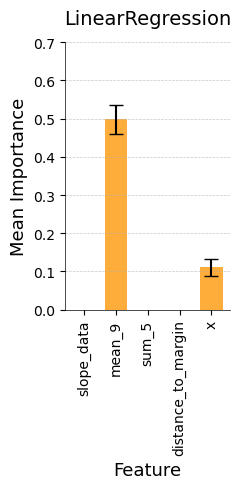

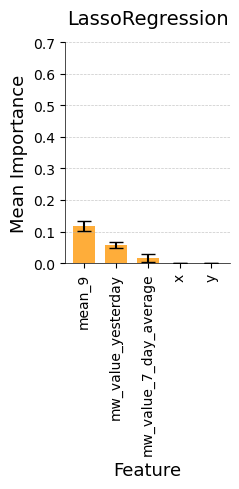

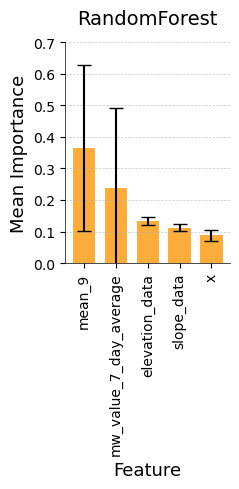

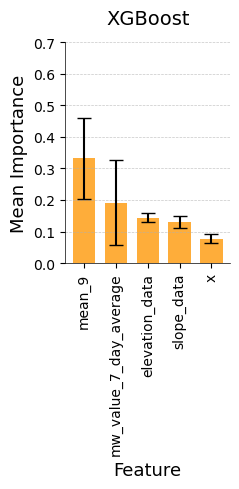

In [155]:
#f.plot_feature_importance(LinReg)

for model in model_list:
    plot_feature_importance(model)
    print()

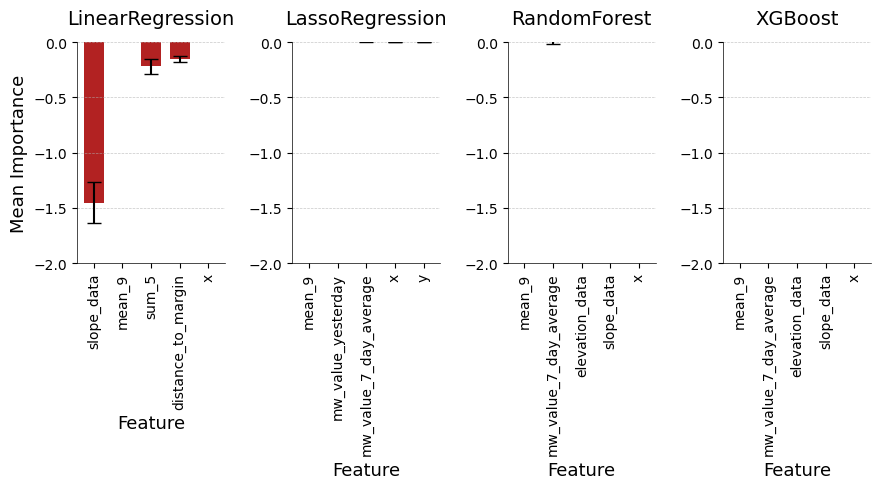

In [169]:
# create subplot figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(9, 5))

for model in model_list:
    feature_importance_df = []
    for mod in model.cv_model_list:
        feature_importance = feature_importance_dict(mod, model.columns)
        if len(feature_importance_df) == 0:
            feature_importance_df = pd.DataFrame(feature_importance, index=[0])
        else:
            feature_importance_df = pd.concat(
                [feature_importance_df, pd.DataFrame([feature_importance])],
                ignore_index=True,
            )

    # sort features by mean importance in descending order by absolute value
    mean_importances = feature_importance_df.mean()
    mean_importances_abs = np.abs(mean_importances)
    sorted_index = mean_importances_abs.sort_values(ascending=False).index[:5]
    mean_importances = mean_importances[sorted_index][:5]
    feature_names = mean_importances.index[:5]

    """
    # assign colors to positive and negative features
    # #9c3605
    colors = ["firebrick" if imp < 0 else "#fead3a" for imp in mean_importances]

    # plot mean feature importance as bar plot with std
    fig, ax = plt.subplots()
    ax.bar(
        feature_names,
        mean_importances,
        yerr=feature_importance_df[sorted_index].std(),
        capsize=5,
        color=colors,
    )
    ax.set_xlabel("Feature")
    ax.set_ylabel("Mean Importance")
    ax.set_title("Feature Importance")
    ax.tick_params(axis="x", rotation=90)

    plt.show()
    """

    # Assign colors to positive and negative features
    colors = ["firebrick" if imp < 0 else "#fead3a" for imp in mean_importances]

    # add suplot to figure
    ax = axes[model_list.index(model)]


    # Plot mean feature importance as a bar plot with standard deviation
    #fig, ax = plt.subplots(figsize=(2.5, 5))
    ax.bar(
        feature_names,
        mean_importances,
        yerr=feature_importance_df[sorted_index].std(),
        capsize=5,
        color=colors,
        width=0.7,
    )
    # set the y-lim to 0.7
    ax.set_ylim(-2,0)

    # Set axis labels and title
    ax.set_xlabel("Feature", fontsize=13)
    if model.name == "LinearRegression":
        ax.set_ylabel("Mean Importance", fontsize=13)
    ax.set_title(model.name, fontsize=14, pad=13)

    # Rotate x-axis labels for better visibility
    ax.tick_params(axis="x", rotation=90)

    # Set grid lines
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

    # Customize spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()

###########
# to get model params:
# model.cv_model_list[0].get_params()

In [32]:
feature_importance_df = []
for model in model_list:
    for mod in model.cv_model_list:
        feature_importance = f.feature_importance_dict(mod, model.columns)
        if len(feature_importance_df) == 0:
                feature_importance_df = pd.DataFrame(feature_importance, index=[0])
        else:
            feature_importance_df = pd.concat(
                [feature_importance_df, pd.DataFrame([feature_importance])],
                ignore_index=True,
            )

    # sort features by mean importance in descending order by absolute value
    mean_importances = feature_importance_df.mean()
    print(model.name)
    print(mean_importances)
    print()

LinearRegression
x                         0.110506
y                        -0.035898
mw_value                 -0.077124
mean_3                   -0.050731
mean_9                    0.497473
sum_5                    -0.220134
mw_value_yesterday        0.070658
mw_value_7_day_average    0.089185
hours_of_daylight         0.040591
elevation_data           -0.049884
slope_data               -1.455676
aspect_data               0.020444
distance_to_margin       -0.152848
dtype: float64

LassoRegression
x                         0.055253
y                        -0.017949
mw_value                 -0.038562
mean_3                   -0.025366
mean_9                    0.307585
sum_5                    -0.110067
mw_value_yesterday        0.064564
mw_value_7_day_average    0.052338
hours_of_daylight         0.020295
elevation_data           -0.024942
slope_data               -0.727838
aspect_data               0.010222
distance_to_margin       -0.076424
dtype: float64

RandomForest
x           

In [115]:
DT = f.load_object('DecisionTree')

In [22]:
DT.columns

Index(['x', 'y', 'mw_value', 'mean_3', 'mean_9', 'sum_5', 'mw_value_yesterday',
       'mw_value_7_day_average', 'hours_of_daylight', 'elevation_data',
       'slope_data', 'aspect_data', 'distance_to_margin'],
      dtype='object')

In [175]:
dir(DT.final_model)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_prune_tree',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_X_predict',
 '_validate_data',
 '_validate_params',
 'apply',
 'ccp_alpha',
 'class_weight',
 'cost_complexity_pruning_path',
 'criterion',
 'decision_path',
 'feature_importances_',
 'feature_names_in_',
 'fit',
 'get_depth',
 'get_n_leaves',
 'get_params',
 'max_

In [ ]:
# can you transform the min-max normalized value 0.0442 back to normal scale with min =0 and max = 90
0.0442 * (90-0) + 0 = 3.978 

In [201]:
# rename columns of DT.columns


In [257]:
# rename columns of DT.columns
cols = [x.replace("dist_margin", "d_margin") for x in cols]
cols

['x',
 'y',
 'mw_value',
 'mean_3',
 'mean_9',
 'sum_5',
 'mw_yest.',
 'mw_7davg.',
 'hours_of_daylight',
 'elev.',
 'slope',
 'aspect_data',
 'd_margin']

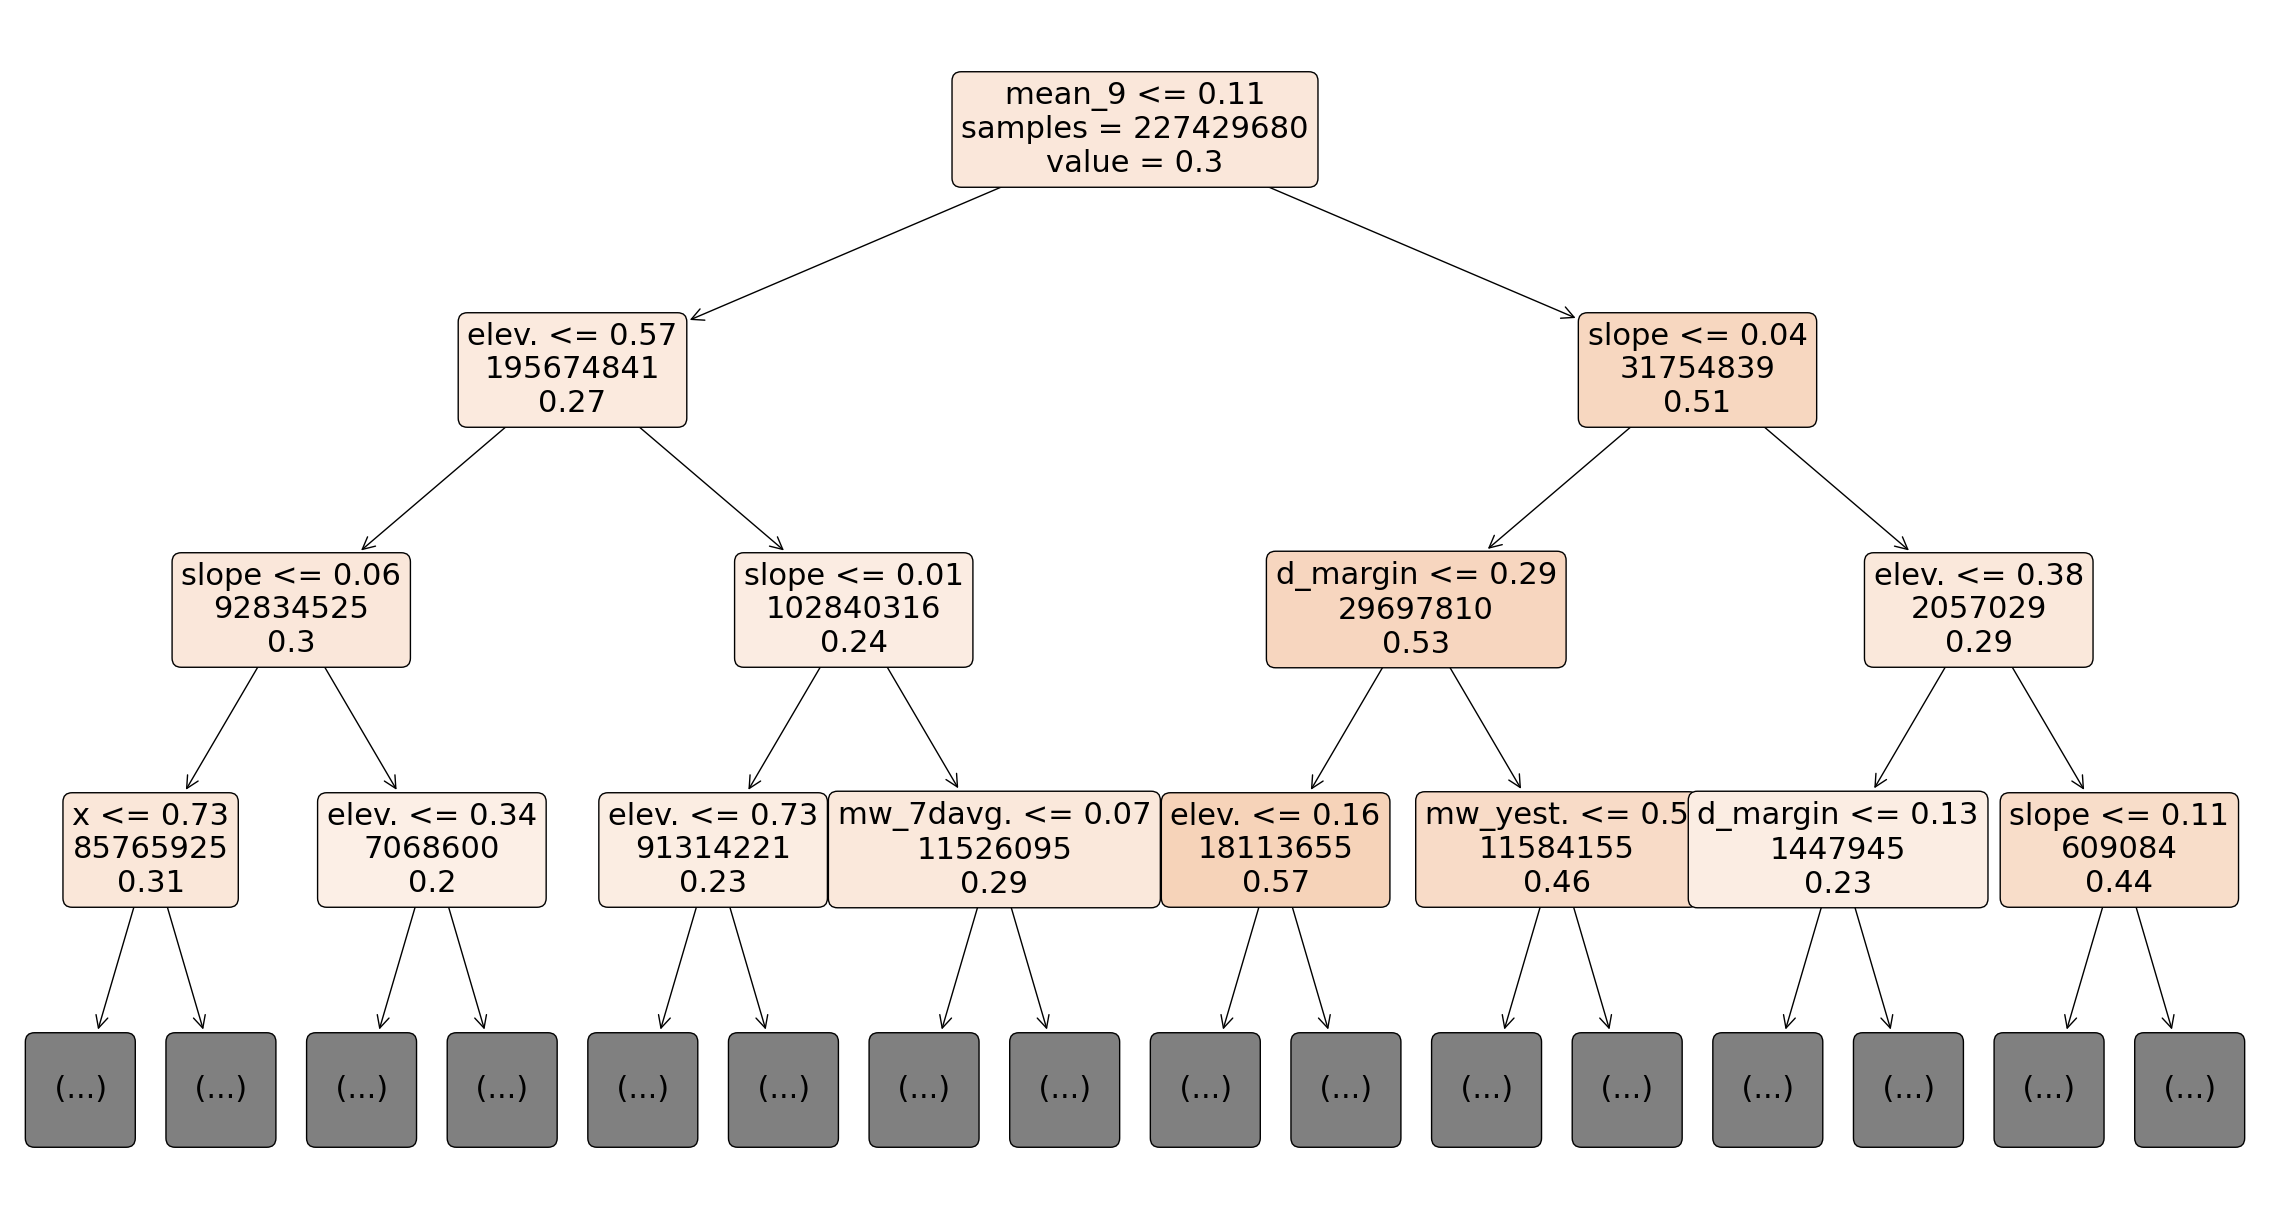

In [267]:
from sklearn import tree
import matplotlib.pyplot as plt

# Plot the decision tree
fig, ax = plt.subplots(figsize=(25,15))
#tree.plot_tree(DT.final_model, max_depth=1,  feature_names=DT.columns, class_names=True, filled=True, ax=ax)
# do not show the samples in the leaf nodes
tree.plot_tree(DT.final_model, max_depth=3,  feature_names=cols, class_names=False, filled=True, ax=ax, impurity=False, rounded=True, precision=2, fontsize=12, label="root")
# do not include the number of samples in the leaf nodes


# increase fontsize of the leaf nodes
import matplotlib
for text in ax.get_children():
    if isinstance(text, matplotlib.text.Text):
        text.set_fontsize(22)
# Remove the sample size from the leaf nodes
for text in ax.texts:
    if text.get_text().startswith('samples'):
        text.set_text('')
# remove the axis
plt.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
plt.show()

### Model performance

In [4]:
table = f.model_comparison_table(model_list).reset_index()

In [5]:
table

,Model,Set,RMSE,RMSE_std,R2,R2_std
0,LinearRegression,Train,0.182667,0.007470,0.118834,0.008399
1,LinearRegression,Test,0.184476,0.031713,0.048278,0.194516
2,LinearRegression_NoXY,Train,0.183551,0.007386,0.110161,0.008204
3,LinearRegression_NoXY,Test,0.183465,0.024423,0.060173,0.129444
4,RidgeRegression,Train,0.182664,0.007468,0.118860,0.008399
5,RidgeRegression,Test,0.184469,0.031698,0.048343,0.194484
6,LassoRegression,Train,0.180727,0.006904,0.137103,0.015288
7,LassoRegression,Test,0.179078,0.016030,0.099684,0.086524
8,ElasticNetRegression,Train,0.183219,0.007700,0.113534,0.013190
9,ElasticNetRegression,Test,0.185035,0.028033,0.035457,0.208491


In [6]:
table[table['Set']=='Test']

,Model,Set,RMSE,RMSE_std,R2,R2_std
1,LinearRegression,Test,0.184476,0.031713,0.048278,0.194516
3,LinearRegression_NoXY,Test,0.183465,0.024423,0.060173,0.129444
5,RidgeRegression,Test,0.184469,0.031698,0.048343,0.194484
7,LassoRegression,Test,0.179078,0.016030,0.099684,0.086524
9,ElasticNetRegression,Test,0.185035,0.028033,0.035457,0.208491
11,RandomForest,Test,0.197773,0.030502,-0.101216,0.246953
13,XGBoost,Test,0.188516,0.032070,-0.012913,0.300837


## old models

LinearRegression


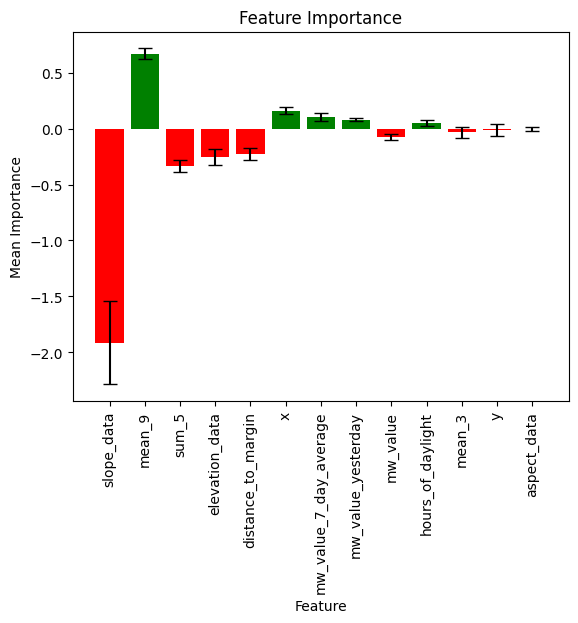

LinearRegression


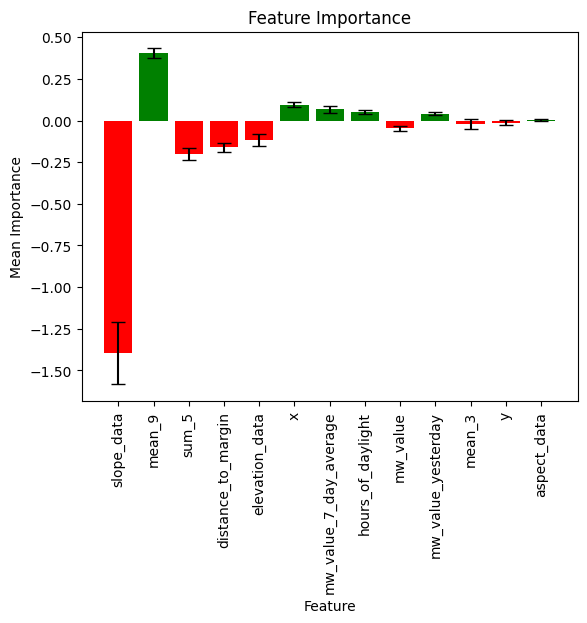

RidgeRegression


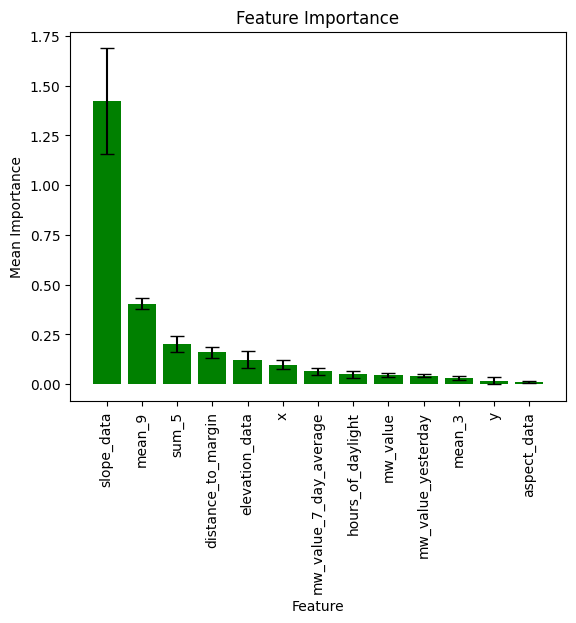

RidgeRegression_WithoutLog


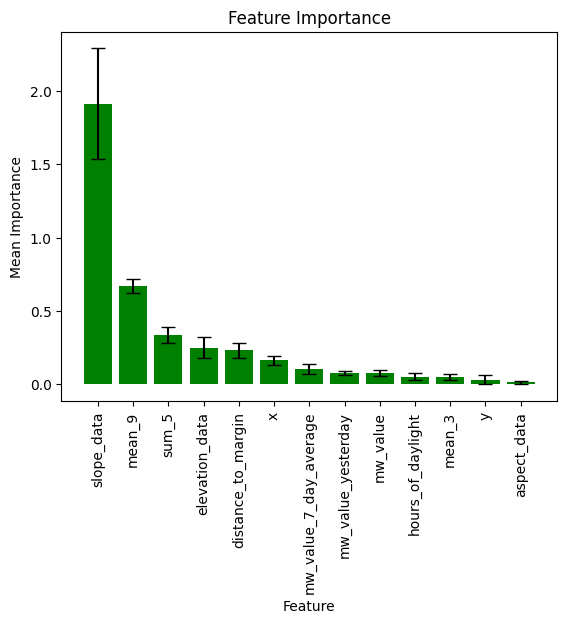

LassoRegression


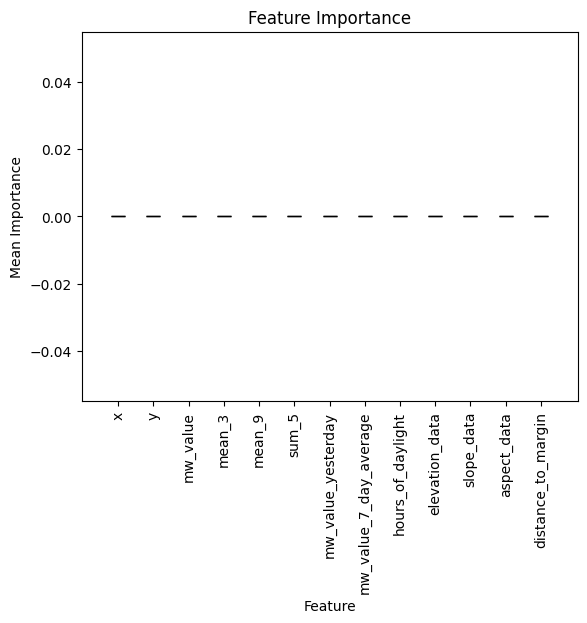

ElasticNetRegression


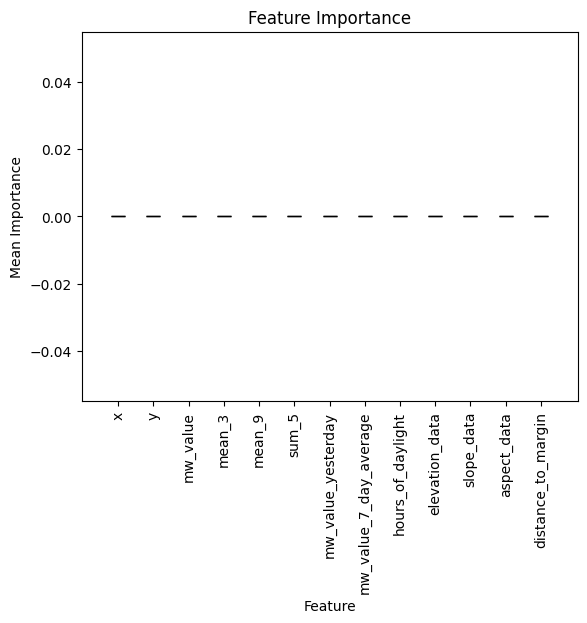

In [8]:
for model in [LinReg_noLog, LinReg, RigdeReg, RidgeReg_noLog, LassoReg, ElasticNetReg]:
    print(model.name)
    f.plot_feature_importance(model)

In [23]:
LinReg_noLog = f.load_object('LinearRegression_WithoutLog')
LinReg = f.load_object('LinearRegression')

RigdeReg = f.load_object('RidgeRegression')
RidgeReg_noLog = f.load_object('RidgeRegression_WithoutLog')

LassoReg = f.load_object('LassoRegression')
ElasticNetReg = f.load_object('ElasticNetRegression')

In [17]:
for model in RigdeReg.cv_model_list:
    print(model.get_params())

{'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
{'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
{'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
{'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
{'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


In [18]:
for model in LassoReg.cv_model_list:
    print(model.get_params())

{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [4]:
LinReg_noXY = f.load_object('LinearRegression_NoXY')

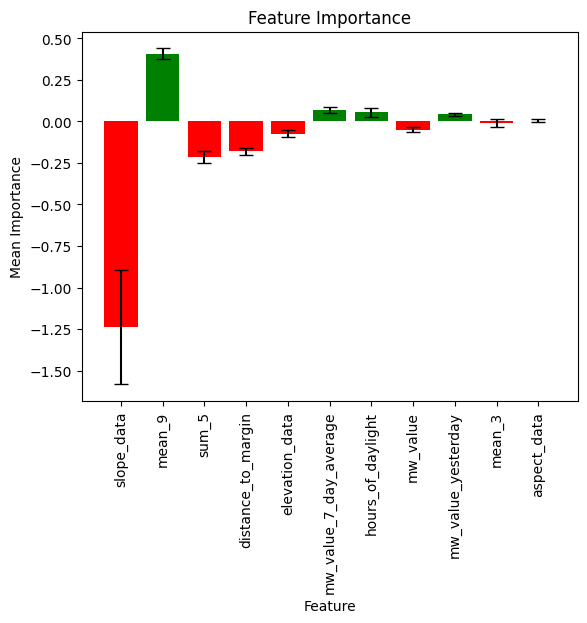

In [5]:
f.plot_feature_importance(LinReg_noXY)

In [13]:
f.model_comparison_table([LinReg_noXY, LinReg])

RMSE  RMSE_std        R2    R2_std
Model                 Set                                          
LinearRegression_NoXY Train  0.033267  0.001241  0.125254  0.009330
                      Test   0.035891  0.008988  0.044028  0.219795
LinearRegression      Train  0.033137  0.001464  0.128257  0.007396
                      Test   0.036065  0.008292  0.027555  0.130037

In [ ]:
f.model_comparison_table([LinReg_noXY, LinReg])

In [22]:
RidgeReg.get_results()

NameError: name 'RidgeReg' is not defined

In [7]:
# hyperparameter analysis

In [10]:
# get hyperparameters of all 7 models
LassoReg.cv_model_list

[Lasso(alpha=0.5),
 Lasso(alpha=0.5),
 Lasso(alpha=0.5),
 Lasso(alpha=0.5),
 Lasso(alpha=0.5)]

In [11]:
for i in range(5):
    print(LassoReg.cv_model_list[i].get_params())

{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [12]:
for i in range(5):
    print(ElasticNetReg.cv_model_list[i].get_params())

{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selectio